In this notebook I try to fit a small CNN to the extracted faces to see if it is easy to get about the same score than with boosting on the meta features

# Importing the faces

In [1]:
import tensorflow as tf
import time
%matplotlib inline

In [2]:
from scipy.ndimage import imread

In [3]:
import os
import matplotlib.pyplot as plt
from scipy import misc
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from spearman import score_function
import time

all_faces = {int(number[::-1][4:][::-1]): "data/extracted_faces/" + number
                  for number in os.listdir("data/extracted_faces")
                  if number[::-1][:4] == 'gpj.'}

bw = imread(all_faces[1]).mean(axis=2)/255.  # black and white normalized
bw = bw.reshape((-1,))  # 10k features

X = np.zeros((len(all_faces), 10**4))

for i in range(13000):
    if i % 1000==0:
        print i
    im = imread(all_faces[i+1])
    if len(im.shape)>2:
        X[i,:] =  imread(all_faces[i+1]).mean(axis=2).reshape((-1,))/255.
    else:
        X[i, :] = imread(all_faces[i + 1]).reshape((-1,)) / 255.


# read .csv using pandas
y = pd.read_csv("data/training_outputs.csv", delimiter=";").set_index("ID")
y = y.as_matrix()

# store id's
X_ids = range(1, 13001)

# cut into test, train
X_train, X_test, y_train, y_test = train_test_split(X[0:10000], y, test_size=0.3, random_state=42)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [4]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

### Real tuto

In [5]:
import tensorflow as tf
tf.reset_default_graph()
config = tf.ConfigProto()
# config.device_count = {'GPU': 0}
config.gpu_options.allow_growth = True
config.log_device_placement=True
sess = tf.InteractiveSession(config=config)
#sess = tf.InteractiveSession()

# Multilayer convnet

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 10000])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [8]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [9]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

In [10]:
x_image = tf.reshape(x, [-1,100,100,1])

In [11]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [12]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [13]:
W_fc1 = weight_variable([25 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 25*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [14]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [15]:
W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [16]:
mse = tf.reduce_mean((y_conv - y_)**2)
train_step = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
mse.eval(feed_dict={
        x:X_train[0:500,:],y_: y_train[0:500,:], keep_prob: 1.0})

69.257248

In [19]:
type(X_train[0,0])

numpy.float32

In [57]:
starts = time.time()
for global_it in range(10):
    for i in range(70):
        batch = (X_train[(i*100):((i+1)*100),:], y_train[(i*100):((i+1)*100),:])
        if (i+1) % 70 == 0:
            train_mse = sess.run(mse, feed_dict={
                x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training mse %g"%(i, train_mse))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print("test mse %g"%mse.eval(feed_dict={
        x: X_test[0:100,:], y_: y_test[0:100,:], keep_prob: 1.0}))

print("Running time: ", time.time() - starts)

step 69, training mse 9.86338
test mse 13.8066
step 69, training mse 9.36038
test mse 14.1305
step 69, training mse 9.58095
test mse 14.1747
step 69, training mse 9.45312
test mse 13.9358
step 69, training mse 8.24423
test mse 14.0094
step 69, training mse 8.3874
test mse 14.1087
step 69, training mse 7.75
test mse 14.0419
step 69, training mse 7.92772
test mse 14.4244
step 69, training mse 7.95099
test mse 14.3925
step 69, training mse 7.58508
test mse 14.5898
('Running time: ', 57.73740816116333)


In [58]:
print("test mse %g"%mse.eval(feed_dict={
    x: X_test[0:500], y_: y_test[0:500], keep_prob: 1.0}))

test mse 15.1475


In [59]:
preds = np.array([[]]).reshape((-1,1))
for i in range(30):
    preds = np.vstack((
        preds, 
        y_conv.eval(feed_dict={x: X_test[(i*100):((i+1)*100),:], y_: y_test[(i*100):((i+1)*100),:], keep_prob: 1.0})
    ))

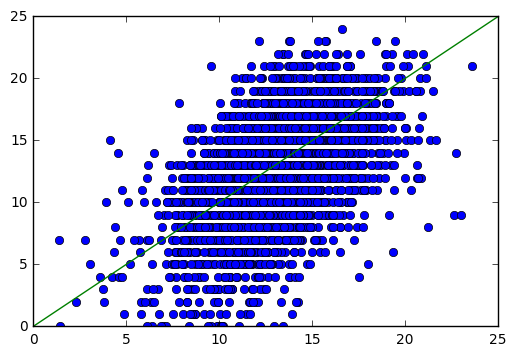

In [60]:
plt.plot(preds, y_test, "o")
plt.plot([0, 25], [0, 25])

In [61]:
from spearman import score_function

In [62]:
score_function(y_pred=np.round(preds), y_true=y_test)

0.5079217835710067